## Importing Libraries and Custom packages 📦

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Github/Biometric

Mounted at /content/drive
/content/drive/My Drive/Github/Biometric


In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
from sklearn import svm, metrics
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import load_model

import matplotlib
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from FUNC_script import *
from Injection import Poison_Attack

## Loading Face-Net model and System Face detector(SVM- Oneclass)

In [3]:
# Load FaceNet Model
model = load_model('Template_poisoning/model/facenet_keras.h5', compile= False)
model.trainable= False

# Load Svm Classifier
clf = svm.OneClassSVM(kernel='linear', nu= 0.02)

# Load Svm Classifier
clf_pca = svm.OneClassSVM(kernel='rbf', nu= 0.04)

## Data Loading and Visualization🔍

In [4]:
# Read Images (160x160x3)
def load_img(path, resize=None):
    img= Image.open(path)
    img= img.convert('RGB')
    if resize is not None:
        img= img.resize((resize, resize))
    return np.asarray(img)


# 128 -> 2 dim pca 
def convert_pca(x, ret= False):
  pca= PCA(n_components=2)
  x= pca.fit_transform(x)
  if ret:
    return pca, x
  return x

In [5]:
# Data  Loading
def load_data(dir):
  X=[]
  for i, sample in enumerate(os.listdir(dir)):
    image= load_img(os.path.join(dir, sample))
    image = cv2.resize(image, (160, 160))
    X.append(image/255.0)
  return np.array(X)

adv_x= load_data('Template_poisoning/Croped_data/adversary_images')
adv_x_copy= adv_x.copy() # Copy of X
print('Adversarial Batch:',adv_x.shape)

Target_x= load_data('Template_poisoning/Croped_data/target_images')
print('Target Batch:',Target_x.shape)

Adversarial Batch: (24, 160, 160, 3)
Target Batch: (75, 160, 160, 3)


## Data(legitimate) fitting in System detectoin model 

1. We decide to use a linear kernel for SVM as this was the best performing one in terms of recognition performance.



2.  To account for the age
of samples in the template, i.e., older samples might be considered
less relevant than recent samples, we include two different weighting schemes: (i) **flat**, (ii) **sigmoid**.
   *  In the flat weighting schemes,
each sample in the template is considered equally important in the
decision.
   *  In the sigmoid scheme the weight of each sample (*wi*)
is computed with a sigmoid function prioritizing recent samples

In [54]:
# Main System Face Detector
sys_clf= Poison_Attack(clf, model.predict(Target_x))
sys_clf.fit(sample_weight= 'flat')

### Sample & Model 2D Boundary/classification Wall Visualization 

In [7]:
Target_x_128= model.predict(Target_x)
adv_x_128=  model.predict(adv_x)

# Target_x_2= convert_pca(Target_x_128)
# adv_x_2= convert_pca(adv_x_128)

mix_128= np.concatenate([adv_x_128, Target_x_128])  #0->23(adv_x_128), 24->36(Target_x_128)
pca, mix_2= convert_pca(mix_128, ret= True)

clf_pca.fit(mix_2[24:, :])
print("Svm (OneClassSVM) 'clf_pca' Trained/Fitted sucessfully for Visulization Purpose")

Svm (OneClassSVM) 'clf_pca' Trained/Fitted sucessfully for Visulization Purpose


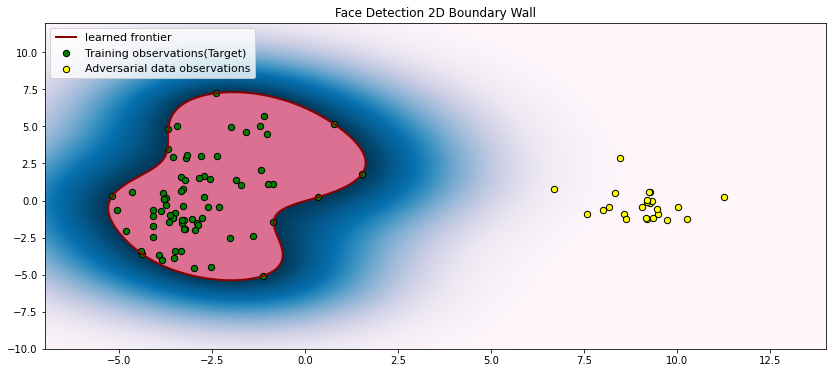

In [8]:
xx, yy = np.meshgrid(np.linspace(-12, 14, 1000), np.linspace(-14, 12, 1000))

# plot the line, the points, and the nearest vectors to the plane
Z = clf_pca.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize= (14, 6))
plt.title("Face Detection 2D Boundary Wall")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 400), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(mix_2[24:, 0], mix_2[24:, 1], c='green', s=s, edgecolors='k')
b2 = plt.scatter(mix_2[:24, 0], mix_2[:24, 1], c='yellow', s=s,edgecolors='k')


plt.axis('tight')
plt.xlim((-7, 14))
plt.ylim((-10, 12))
plt.legend([a.collections[0], b1, b2],
           ["learned frontier", "Training observations(Target)",
            "Adversarial data observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.show()

##  Poisoning Sample Generation

In [9]:
def loss_object(pred, label, delta_x, direction= False):
  # Loss= euclidean distance + Delta_x pixel Variance
  dist= Euclidean_dist(pred, label)
  variance= Sample_variance(delta_x)
  if direction:
    sc= tf.math.subtract(1.0, tf.math.divide(1.0, label.shape[0]))

    vector_mean= tf.math.multiply(dist, sc)
   
    target_dir= tf.math.multiply(vector_mean, dist)
    Loss= tf.math.add(target_dir, tf.cast(variance, dist.dtype))
    return Loss

  Loss= tf.math.add(tf.cast(dist, variance.dtype), variance)
  return Loss


def back_propagate(model, X, mask, delta_x, label, direction= False):
  with tf.GradientTape() as g:
      g.watch(delta_x)
      X_batch= Generate_sample(X, delta_x, mask)
      feature= model(X_batch)
      loss= loss_object(pred= feature, label= label, delta_x= delta_x, direction= direction)
  # Get the gradients of the loss w.r.t to the input image.
  gradient = g.gradient(loss, delta_x)
  return gradient, tf.reduce_mean(loss).numpy()

In [10]:
adv_centroid= Centroid(adv_x_128, axis= 0) #(1 x 128)
print(adv_centroid.shape)
adv_centroid= Generate_target(adv_centroid, batch_size=adv_x.shape[0]) #(24 x 128)
print(adv_centroid.shape)

# centre of target sample features
Target_sample= Centroid(Target_x_128)
Target_sample= Generate_target(Target_sample, batch_size= adv_x.shape[0])
Target_sample.shape

(128,)
(24, 128)


(24, 128)

In [11]:
def schedule_lr(Lambda_target, ep):
  if ep>= 300:
      return 0.06
  elif (ep<20) or (ep>210):
    return 0.1
  elif (ep>20) and (ep<210):
      return 0.2
  else:
    return Lambda_target

In [12]:
def Get_pubertation(model, adv_x, adv_centroid, Target_x, direction= True,
                    epoch= 160, Lambda_x= 0.5, Lambda_target= 0.2):
  # Get Binary  Mask
  mask= load_img('Template_poisoning/final_mask.png')                           #Sacle(0-255), RGB
  mask= mask/255.0

  delta_x= np.random.uniform(low=0.0, high=1.0, size=adv_x.shape)               # Scale(0-1)

  # Tf Variables
  X= tf.Variable(adv_x, dtype=tf.float64)
  delta_x= tf.Variable(delta_x, dtype=tf.float64)
  mask= tf.Variable(mask, dtype=tf.float64)
  # Xc= tf.Variable(adv_centroid)
  # Target= tf.Variable(Target_x)
  print("Processing Pubertations for Adversarial's centroid")
  for ep  in range(epoch+1):
    grad, loss= back_propagate(model, X, mask, delta_x,
                               adv_centroid, direction= True)
    # Gradient step
    delta_x= delta_x - Lambda_x*grad
    if ep%20 == 0:
      print('Epoch: {}  Loss: {:.3f}'.format((ep), loss))


  delta=[]
  delta.append(tf.identity(delta_x))
  print()
  print("Processing Pubertation Towards Target's pubertation")

  for ep  in range(int(3*epoch+ 1)):
    grad, loss= back_propagate(model, X, mask, delta_x,
                               Target_x, direction= True)
    # Gradient step
    Lambda_target= schedule_lr(Lambda_target, ep)
    delta_x= delta_x - Lambda_target*grad
    if ep < 200:
      delta.append(tf.identity(delta_x))
    else:
      if ep%2==0:
         delta.append(tf.identity(delta_x))

    if ep%20 == 0:
      print('Epoch: {}, Loss: {:.3f}'.format((ep), loss))


  return delta



In [13]:
pubertation_list= Get_pubertation(model, adv_x, adv_centroid, Target_x= Target_sample,
                   direction= True, epoch= 160, Lambda_x= 0.5, Lambda_target= 0.2)

Processing Pubertations for Adversarial's centroid
Epoch: 0  Loss: 256.866
Epoch: 20  Loss: 129.528
Epoch: 40  Loss: 85.829
Epoch: 60  Loss: 55.991
Epoch: 80  Loss: 38.900
Epoch: 100  Loss: 31.487
Epoch: 120  Loss: 30.409
Epoch: 140  Loss: 27.780
Epoch: 160  Loss: 26.622

Processing Pubertation Towards Target's pubertation
Epoch: 0, Loss: 173.820
Epoch: 20, Loss: 79.006
Epoch: 40, Loss: 72.130
Epoch: 60, Loss: 64.784
Epoch: 80, Loss: 61.426
Epoch: 100, Loss: 59.829
Epoch: 120, Loss: 58.631
Epoch: 140, Loss: 57.503
Epoch: 160, Loss: 56.863
Epoch: 180, Loss: 55.710
Epoch: 200, Loss: 55.183
Epoch: 220, Loss: 49.418
Epoch: 240, Loss: 48.835
Epoch: 260, Loss: 48.658
Epoch: 280, Loss: 48.446
Epoch: 300, Loss: 48.227
Epoch: 320, Loss: 47.243
Epoch: 340, Loss: 47.143
Epoch: 360, Loss: 47.061
Epoch: 380, Loss: 46.975
Epoch: 400, Loss: 46.928
Epoch: 420, Loss: 46.831
Epoch: 440, Loss: 46.752
Epoch: 460, Loss: 46.677
Epoch: 480, Loss: 46.635


In [14]:
# Function for Processing nth Pubertation on Data and transformation towards feature space(128)

def load_pubertation(adv_x, pubertation_list, ind, mask, feature_space= False):
  delta_x= pubertation_list[ind].numpy()
  if feature_space:
    return (adv_x*(1-mask))+ delta_x*mask
  return model.predict((adv_x*(1-mask))+ delta_x*mask)

In [15]:
mask= load_img('Template_poisoning/final_mask.png')                           #Sacle(0-255), RGB
mask= mask/255.0

## Poisoning Algorithm.

### 1. Poisoning Attack Injection


In [36]:
# IAR1 is Zero(0) because it is outside of system model's decision boundary
IAR1= sys_clf.Calculate_AR(model.predict(adv_x))
IAR1

0.0

In [55]:
thresh1= 0.54
thresh2= 0.56

counter= 0
sample_centroid= Centroid(sys_clf.xtrain)

cosine_similarity=[]

while (IAR1 < thresh1):
  i= 0
  adv_x_with_glass= load_pubertation(adv_x, pubertation_list, i, mask)
  IAR2= sys_clf.Calculate_AR(adv_x_with_glass)

  while (IAR2< thresh2):
    i+= 1
    adv_x_with_glass= load_pubertation(adv_x, pubertation_list, i, mask)
    IAR2= sys_clf.Calculate_AR(adv_x_with_glass)

  sys_clf.Add(adv_x_with_glass)
  if counter>0:
    x0= sample_centroid- sys_clf.xtrain[-1]
    x1= sample_centroid- sys_clf.xtrain[-2]
  
    cosine_similarity.append(tf.math.reduce_sum((x0*x1)/np.linalg.norm(x0)*np.linalg.norm(x1)))


  sys_clf.fit(sample_weight='sigmoid')

  sys_clf.Add_IAR(IAR1)
  sys_clf.Add_FRR(1- sys_clf.Calculate_AR(Target_x_128))
  
  IAR1= sys_clf.Calculate_AR(model.predict(adv_x))
  print('IAR1: {:.2f}   Decision_function: {:.2f}'.format(IAR1, sys_clf.model.decision_function(adv_x_128).mean()))
  counter+=1
  #Signed distance to the separating hyperplane.
  #Signed distance is positive(+) for an inlier and negative(-) for an outlier.


IAR1: 0.00   Decision_function: -17.14
IAR1: 0.00   Decision_function: -17.42
IAR1: 0.00   Decision_function: -17.71
IAR1: 0.00   Decision_function: -17.99
IAR1: 0.00   Decision_function: -16.08
IAR1: 0.00   Decision_function: -16.29
IAR1: 0.00   Decision_function: -16.51
IAR1: 0.00   Decision_function: -13.60
IAR1: 0.00   Decision_function: -13.76
IAR1: 0.00   Decision_function: -13.69
IAR1: 0.00   Decision_function: -12.54
IAR1: 0.00   Decision_function: -12.68
IAR1: 0.00   Decision_function: -12.83
IAR1: 0.00   Decision_function: -12.97
IAR1: 0.00   Decision_function: -13.12
IAR1: 0.00   Decision_function: -11.77
IAR1: 0.00   Decision_function: -11.90
IAR1: 0.00   Decision_function: -12.02
IAR1: 0.00   Decision_function: -12.15
IAR1: 0.00   Decision_function: -11.06
IAR1: 0.00   Decision_function: -11.18
IAR1: 0.00   Decision_function: -10.91
IAR1: 0.00   Decision_function: -11.01
IAR1: 0.00   Decision_function: -11.12
IAR1: 0.00   Decision_function: -11.23
IAR1: 0.00   Decision_fun

In [56]:
# 58.3% of Attacker's sample is accepted by system detector
IAR1, sys_clf.xtrain.shape

(0.625, (196, 128))

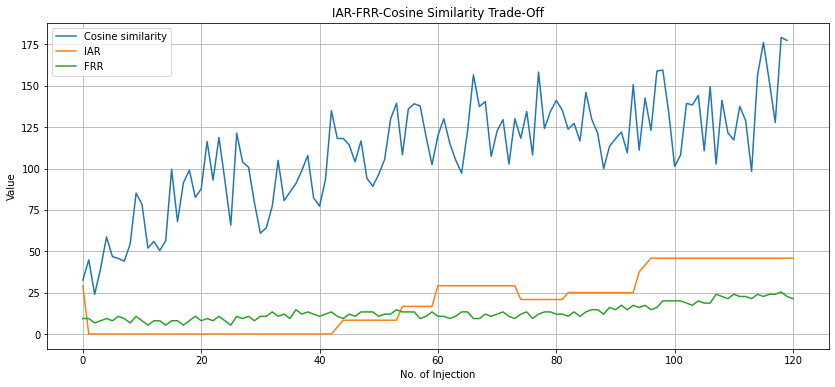

In [65]:
plt.figure(figsize=(14, 6))
plt.plot(cosine_similarity, label = "Cosine similarity")
plt.plot(np.array(sys_clf.IAR)*100, label = "IAR")
plt.plot(np.array(sys_clf.FRR)*100, label = "FRR")
plt.xlabel('No. of Injection')
plt.ylabel('Value')
plt.title('IAR-FRR-Cosine Similarity Trade-Off')
plt.legend()
plt.grid()
plt.show()

In [61]:
df= pd.DataFrame(np.concatenate([adv_x_128, sys_clf.xtrain]))
# (0->23)      Adversarial Damples Data without pubertations (without Glasses)
# (24- 99)     Target Sample Data
# (100-> end)  Adversarial Damples Data with pubertations    (with Glasses)
df['target']= 'User Sample'
#adv_x_128.shape[0]= 24
df.iloc[0: adv_x_128.shape[0], 128]= 'Attacker Sample'   
# adv_x_128.shape[0]+Target_x_128.shape[0] = 99    
df.iloc[adv_x_128.shape[0]+Target_x_128.shape[0] : , 128]= 'Poisoning Sample'  

df1= pd.DataFrame(pca.fit_transform(df.drop(['target'], 1)))
df1['target']= df.target

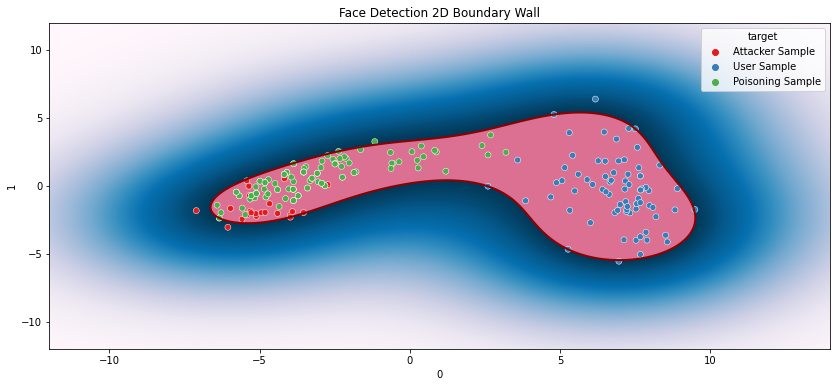

In [63]:
# df1.iloc[: 24, 0:2] are for Attacker samples
clf_pca.fit(df1.iloc[24:, 0:2])

xx, yy = np.meshgrid(np.linspace(-12, 14, 1000), np.linspace(-14, 12, 1000))

# plot the line, the points, and the nearest vectors to the plane
Z = clf_pca.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize= (14, 6))
plt.title("Face Detection 2D Boundary Wall")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 400), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')


sns.scatterplot(x=df1.iloc[:, 0] , y= df1.iloc[:, 1], hue = df1.iloc[:, 2], data= df1, palette='Set1')

plt.axis('tight')
plt.xlim((-12, 14))
plt.ylim((-12, 12))

plt.show()

### 2. POISONING COUNTERMEASURES



<img align="right" src="https://user-images.githubusercontent.com/64481847/96880888-54324880-149b-11eb-9769-4e1f9fcc403d.png">

* We propose a new detection technique, based on the rationale
that poisoning samples will all lie in a predetermined direction in
feature space with respect to the current legitimate user centroid.
The direction is determined based on the location of the attacker
samples.


* Given the user’s current
centroid Xc and a set of template updates {Xi
, Xi+1, ..., Xi+n }, which
we refer to as an update sequence, we compute the direction of the
update at time i: **∆Xi = Xc − Xi**

* and we can obtain the directions at each step as {∆Xi
, ..., ∆Xi+n }.
We then compute the angular similarity for pairs of consecutive updates with the **Cosine Similarity**.

* **The underlying intuition is that COSθi(Cosine Similarity) will be higher for pairs of
poisoning samples compared to legitimate updates because the
poisoning attack needs to shift the current user centroid towards
the adversary’s, which lies in a specific pre-defined direction.**


In [72]:
# Main System Face Detector
# Traning it again with legitimate data
sys_clf= Poison_Attack(clf, model.predict(Target_x))
sys_clf.fit(sample_weight= 'flat')

In [73]:
# IAR1 is Zero(0) because it is outside of system model's decision boundary
IAR1= sys_clf.Calculate_AR(model.predict(adv_x))
IAR1

0.0

In [74]:
thresh1= 0.54
thresh2= 0.56

counter= 0
sample_centroid= Centroid(sys_clf.xtrain)

cosine_similarity2=[]

while (IAR1 < thresh1):
  i= 0
  adv_x_with_glass= load_pubertation(adv_x, pubertation_list, i, mask)
  IAR2= sys_clf.Calculate_AR(adv_x_with_glass)

  while (IAR2< thresh2):
    i+= 1
    adv_x_with_glass= load_pubertation(adv_x, pubertation_list, i, mask)
    IAR2= sys_clf.Calculate_AR(adv_x_with_glass)

  sys_clf.Add(adv_x_with_glass)
  if counter>0:
    x0= sample_centroid- sys_clf.xtrain[-1]
    x1= sample_centroid- sys_clf.xtrain[-2]
  
    cosine_similarity2.append(tf.math.reduce_sum((x0*x1)/np.linalg.norm(x0)*np.linalg.norm(x1)))
    
    if cosine_similarity2[-1] > 140:
       sys_clf.xtrain= sys_clf.xtrain[:-1]
       cosine_similarity2[-1] = 140

       


  sys_clf.fit(sample_weight='sigmoid')

  sys_clf.Add_IAR(IAR1)
  sys_clf.Add_FRR(1- sys_clf.Calculate_AR(Target_x_128))
  
  IAR1= sys_clf.Calculate_AR(model.predict(adv_x))
  print('IAR1: {:.2f}   Decision_function: {:.2f}'.format(IAR1, sys_clf.model.decision_function(adv_x_128).mean()))
  counter+=1
  if counter ==150:
    break


IAR1: 0.00   Decision_function: -17.14
IAR1: 0.00   Decision_function: -15.63
IAR1: 0.00   Decision_function: -15.83
IAR1: 0.00   Decision_function: -16.03
IAR1: 0.00   Decision_function: -16.01
IAR1: 0.00   Decision_function: -15.01
IAR1: 0.00   Decision_function: -14.89
IAR1: 0.00   Decision_function: -12.48
IAR1: 0.00   Decision_function: -12.64
IAR1: 0.00   Decision_function: -12.79
IAR1: 0.00   Decision_function: -8.62
IAR1: 0.00   Decision_function: -8.73
IAR1: 0.00   Decision_function: -8.84
IAR1: 0.00   Decision_function: -8.96
IAR1: 0.00   Decision_function: -9.08
IAR1: 0.00   Decision_function: -9.20
IAR1: 0.00   Decision_function: -7.69
IAR1: 0.00   Decision_function: -7.78
IAR1: 0.00   Decision_function: -7.88
IAR1: 0.00   Decision_function: -7.97
IAR1: 0.00   Decision_function: -8.06
IAR1: 0.00   Decision_function: -8.15
IAR1: 0.00   Decision_function: -8.24
IAR1: 0.00   Decision_function: -8.33
IAR1: 0.00   Decision_function: -8.43
IAR1: 0.00   Decision_function: -8.52
IA

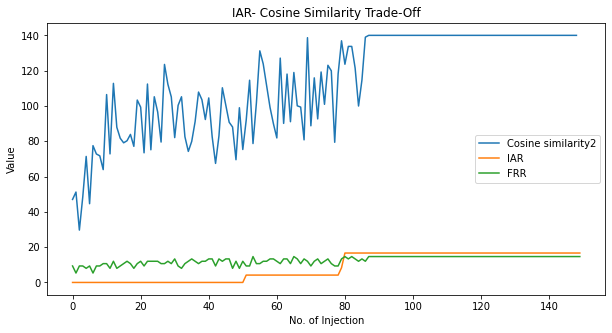

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(cosine_similarity2, label = "Cosine similarity2")
plt.plot(np.array(sys_clf.IAR)*100, label = "IAR")
plt.plot(np.array(sys_clf.FRR)*100, label = "FRR")
plt.xlabel('No. of Injection')
plt.ylabel('Value')
plt.title('IAR- Cosine Similarity Trade-Off')
plt.legend()
plt.show()

In [77]:
df= pd.DataFrame(np.concatenate([adv_x_128, sys_clf.xtrain]))
# (0->23)      Adversarial Damples Data without pubertations (without Glasses)
# (24- 99)     Target Sample Data
# (100-> end)  Adversarial Damples Data with pubertations    (with Glasses)
df['target']= 'User Sample'
#adv_x_128.shape[0]= 24
df.iloc[0: adv_x_128.shape[0], 128]= 'Attacker Sample'   
# adv_x_128.shape[0]+Target_x_128.shape[0] = 99    
df.iloc[adv_x_128.shape[0]+Target_x_128.shape[0] : , 128]= 'Poisoning Sample'  

df1= pd.DataFrame(pca.fit_transform(df.drop(['target'], 1)))
df1['target']= df.target

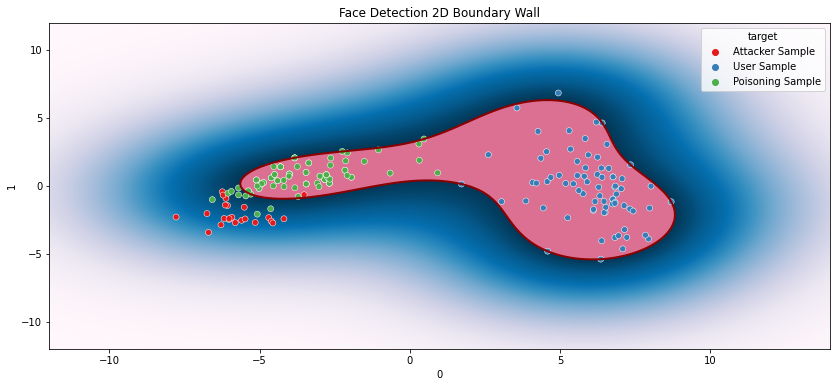

In [85]:
clf_pca.fit(df1.iloc[24:, 0:2])

xx, yy = np.meshgrid(np.linspace(-12, 14, 1000), np.linspace(-14, 12, 1000))

# plot the line, the points, and the nearest vectors to the plane
Z = clf_pca.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize= (14, 6))
plt.title("Face Detection 2D Boundary Wall")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 400), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')


sns.scatterplot(x=df1.iloc[:, 0] , y= df1.iloc[:, 1], hue = df1.iloc[:, 2], data= df1, palette='Set1')

plt.axis('tight')
plt.xlim((-12, 14))
plt.ylim((-12, 12))

plt.show()